In [1]:
r = requests.get("https://i.imgur.com/OJf6rzy.png", stream=True)
					with open("C:/Users/Pray/Pictures/test2.png", 'wb') as out_file:
						shutil.copyfileobj(r.raw, out_file)

SyntaxError: invalid syntax (<ipython-input-1-d476a8862544>, line 1)

Root: C:\Programming\Bubbles\Mask_RCNN
Model: F:\downloads_trash\mask_rcnn_bubbles_0010.h5
Dataset: C:\Programming\Bubbles\MangaBubbles
Processing 1 images
image                    shape: (1728, 1728, 1)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1728, 1728, 1)    min: -123.70000  max:  131.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1728.00000  int32
anchors                  shape: (1, 745767, 4)        min:   -0.20963  max:    1.17258  float32
[0.99646395 0.96930724 0.91903794 0.8566743 ]


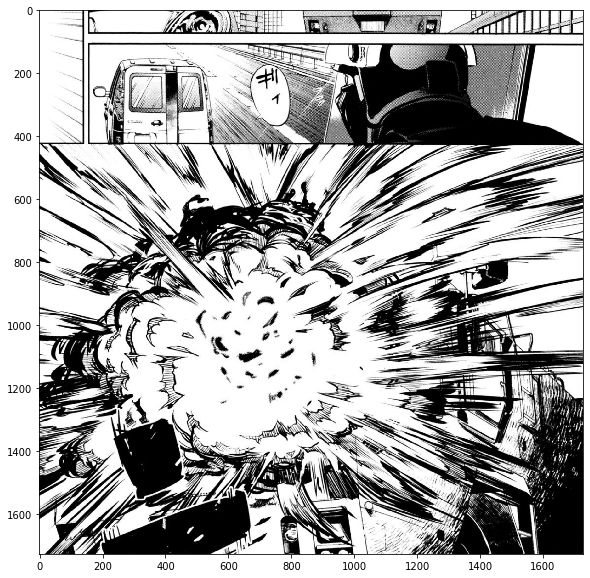

In [11]:
import os

import png

ROOT_DIR= os.path.abspath("../Mask_RCNN/")
MODEL_PATH = os.path.abspath("F:/downloads_trash/mask_rcnn_bubbles_0010.h5")
DATASET_DIR= os.path.abspath("../MangaBubbles/")

print("Root:", ROOT_DIR)
print("Model:", MODEL_PATH)
print("Dataset:", DATASET_DIR)


import sys
import cv2
import numpy as np
import skimage
import copy
import random
import glob
import scipy

sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils, visualize


import tensorflow
tensorflow.logging.set_verbosity(tensorflow.logging.ERROR)


import matplotlib.pyplot as plt


def get_ax(rows=1, cols=1, size=10):
	"""Return a Matplotlib Axes array to be used in
	all visualizations in the notebook. Provide a
	central point to control graph sizes.

	Change the default size attribute to control the size
	of rendered images
	"""
	_, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
	return ax


def makeTransparent(mask, alpha=.6):
	src = mask
	tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
	_, alpha = cv2.threshold(tmp, 0, int(255 * alpha), cv2.THRESH_BINARY)
	b, g, r = cv2.split(src)
	rgba = [b, g, r, alpha]
	dst = cv2.merge(rgba, 4)
	return dst


def blend_transparent(face_img, overlay_t_img):
	# Split out the transparency mask from the colour info
	overlay_img = overlay_t_img[:, :, :3]  # Grab the BRG planes
	overlay_mask = overlay_t_img[:, :, 3:]  # And the alpha plane

	# Again calculate the inverse mask
	background_mask = 255 - overlay_mask

	# Turn the masks into three channel, so we can use them as weights
	overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
	background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

	# Create a masked out face image, and masked out overlay
	# We convert the images to floating point in range 0.0 - 1.0
	face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
	overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

	# And finally just add them together, and rescale it back to an 8bit integer image
	return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))


def flatten(arrs):
	# Flatten blobs into single matrix for viewing
	x = np.zeros((arrs.shape[0], arrs.shape[1]), dtype=np.int32)
	for i in range(arrs.shape[2]):
		x[:, :] += arrs[:, :, i]
	return x

# ==============================================================================


class InferenceConfig(Config):
	BACKBONE = 'resnet50'

	IMAGE_RESIZE_MODE = 'crop'
	IMAGE_MIN_DIM = 1728
	IMAGE_MAX_DIM = 1728

	# TRAIN_ROIS_PER_IMAGE = 30

	# Blech
	NAME = "bubbles"
	NUM_CLASSES = 1 + 1  # background + 3 shapes
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

	IMAGE_CHANNEL_COUNT = 1
	MEAN_PIXEL = np.array([123.7])


inference_config = InferenceConfig()
#inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=ROOT_DIR)
model.load_weights(MODEL_PATH, by_name=True)

imPath= "C:/Programming/Bubbles/MangaBubbles/train_original/images/asuka/1/01_0018.jpg"
imPath= random.choice(glob.glob("C:/Programming/Bubbles/MangaBubbles/train_original/images/asuka/1/*"))

import io
import os
import re
import shutil
import subprocess
import time
import urllib

import discord
import requests

#imPath= "C:/Users/Pray/Pictures/test2.png"
original_image = skimage.io.imread(imPath, as_gray=True)
if np.max(original_image) <= 1:
    original_image = original_image * 255
if len(original_image.shape) == 2:
    original_image = original_image[..., np.newaxis]

original_image = utils.resize_image(original_image, min_dim=inference_config.IMAGE_MIN_DIM,
                                    max_dim=inference_config.IMAGE_MAX_DIM,
                                    min_scale=inference_config.IMAGE_MIN_SCALE,
                                    mode=inference_config.IMAGE_RESIZE_MODE)[0]
disp_image = np.concatenate((original_image, original_image, original_image), axis=2)

get_ax().imshow(disp_image.astype(np.uint8))

results = model.detect([original_image], verbose=1)

r = copy.deepcopy(results[0])
print(r['scores'])

inds = []
for i in reversed(range(len(r['scores']))):
    if r['scores'][i] > .98:
        break
    else:
        inds.append(i)

r['masks'] = np.delete(r['masks'], inds, 2)
r['scores'] = np.delete(r['scores'], inds, 0)
r['class_ids'] = np.delete(r['class_ids'], inds, 0)
r['rois'] = np.delete(r['rois'], inds, 0)



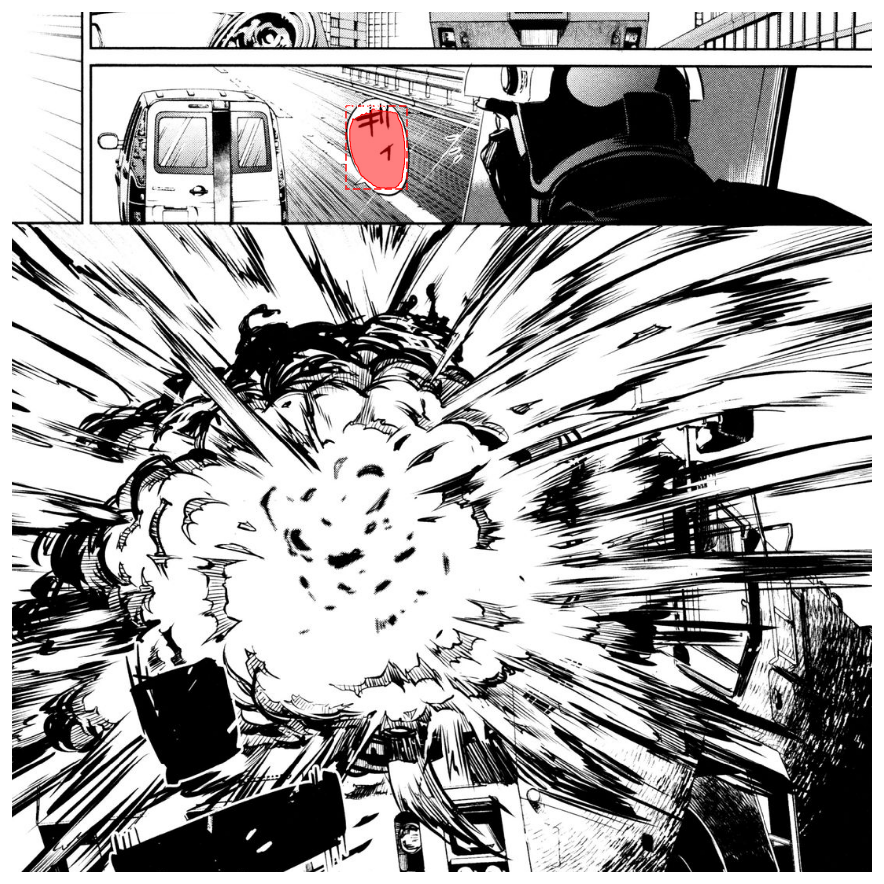

save 255 (1728, 1728, 3)


In [19]:
im = visualize.display_instances(disp_image, r['rois'], r['masks'], r['class_ids'],
	                             ['a'] * 123, r['scores'])

print('save',np.max(im),im.shape)
png.from_array(im.astype(np.uint8), mode="RGB").save(f"C:/Users/Pray/Pictures/test4.png")
#get_ax().imshow(im.astype(np.uint8))
from PIL import Image
img = Image.fromarray(im)
img.save("C:/Users/Pray/Pictures/test4.png")

__, greyImage = cv2.threshold(original_image, 240, 1, cv2.THRESH_BINARY)

In [2]:
# generate blobs and move to separate array
print(greyImage.dtype, np.max(greyImage))
greyImage= (greyImage*255).astype(np.uint8)
print(greyImage.dtype, np.max(greyImage))

uint8 1
uint8 255


h
6633
[127   0  15   4  34]
h
(1728, 1728, 1)
(1728, 1728)
h
h
h
255.0
(1728, 1728, 30)
h
255.0
1728
set()
(1728, 1728, 1)


SyntaxError: 'return' outside function (<ipython-input-3-570d3ae8c5e1>, line 68)

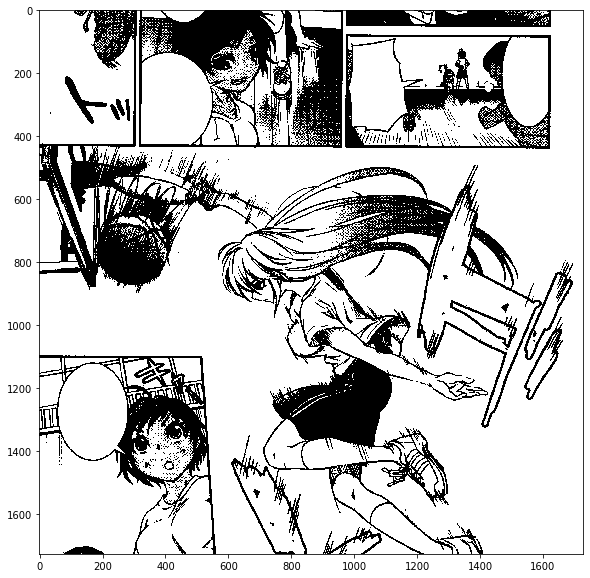

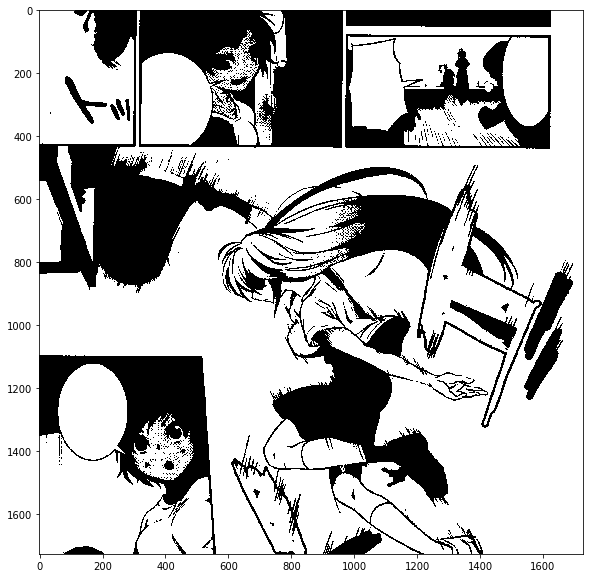

In [3]:
output = cv2.connectedComponentsWithStats(greyImage, 8, cv2.CV_16U)
print('h')
print(len(output[2]))
print(output[2][2])
adds = [x for x in range(len(output[2])) if output[2][x][4] > 8000]
# cents= [x for x in range(len(output[2])) if x in adds]
print('h')
# print(len(adds), len(cents))

arr = np.zeros(original_image.shape)
print(arr.shape)
out = output[1][..., np.newaxis]
print(output[1].shape)
c = 0
for val in adds[1:]:
    arr = np.concatenate((arr, out == val), axis=2)
    c += 1
print('h')

greyImage = greyImage * 255
get_ax().imshow(greyImage.astype(np.uint8), cmap='Greys_r')

print('h')
arr = arr * 255

print('h')
print(np.max(arr))
print(arr.shape)
print('h')
arr2 = flatten(arr.astype(np.uint8))
disp_image = np.dstack((arr2, arr2, arr2))
get_ax().imshow(disp_image.astype(np.uint8), cmap='Greys_r')
print(np.max(arr))

print(len(r['masks']))
# print(output[3])
okays = set([])
for msk in range(r['masks'].shape[2]):
    mask = r['masks'][:, :, msk]
    print(mask.shape)
    get_ax().imshow(mask.astype(np.uint8), cmap='Greys_r')
    for i in range(len(adds)):
        # print(output[3][adds[i]])
        coords = output[3][adds[i]]
        coords = coords.astype(np.uint16)
        # print(coords)
        if mask[coords[1]][coords[0]] and np.count_nonzero(
                np.logical_and(mask, output[1][:, :] == adds[i])) > 1000:
            print(coords)
            okays.add(adds[i])
print(okays)

show = original_image
print(show.shape)

for b in okays:
    test = output[1][:, :] == b
    test = test * 255

    fill = scipy.ndimage.binary_fill_holes(test).astype(np.uint8) * 255

    show = np.maximum(fill[:, :, np.newaxis], show)
    disp = np.concatenate((show, show, show), axis=2)
    get_ax().imshow(disp.astype(np.uint8), cmap='Greys_r')

png.from_array(np.uint8(show), mode="L").save(f"C:/Users/Pray/Pictures/test3.png")
#await message.channel.send(file=discord.File('C:\\Users\\Pray\\Pictures\\test3.png'))